# Music generation

In [this project](https://github.com/RasmusML/musicHMM), we will generate music notes using hidden markov models. The models are trained on chorales composed by Bach.

We will explore 4 hidden markov models. The first model is a standard HMM and implemented from scratch. This model assumes a single note is played at each timestep. 
The remaning 3 models are implemented using the deep probabilistic library Pyro and support a variable number of notes played at the same timestep. Using Pyro, we don't need to implement the (modified) Baum-Welch algorithm for each model variant in order to estimate the models' parameters - as Pyro uses backpropagation under the hood. By defining an approximate posterior distribution (called a "guide" in Pyro), a model's parameters can be estimated.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.infer.autoguide import AutoDelta, AutoNormal
from pyro.optim import Adam, ClippedAdam
from pyro.ops.indexing import Vindex

import torch
from torch.distributions import constraints

from utils import *
from hmm import HMM

np.random.seed(0)
pyro.set_rng_seed(42)

## Data exploration

The "JSB chorales" dataset is a set of short, four-voice pieces of music well-noted for their stylistic homogeneity. The chorales were originally composed by Johann Sebastian Bach in the 18th century. He wrote them by first taking pre-existing melodies from contemporary Lutheran hymns and then harmonising them to create the parts for the remaining three voices. The version of the dataset used canonically in representation learning contexts consists of 382 such chorales. Lastly, the timing of each note in the dataset is the same (here always one quarter note) and notes are stored in MIDI format.

Let's load the data.

In [3]:
data = load_jsb_chorales()

In [4]:
print(f"Number of chorales: {len(data)}")

Number of chorales: 382


Let's shuffle the data to ensure no biased ordering occurs.

In [5]:
idxs = np.arange(len(data))
np.random.shuffle(idxs)
data = [data[i] for i in idxs]

Let's look at the range of the notes.

In [6]:
notes = [note for chorale in data for t_note in chorale for note in t_note]
lowest_note = np.min(notes)
highest_note = np.max(notes)

print(f"Lowest note:  {str_number_to_note(lowest_note)} ({lowest_note})")
print(f"Highest note: {str_number_to_note(highest_note)} ({highest_note})")

Lowest note:  A2 (33)
Highest note: D7 (86)


Let's look at the distributions of the data.

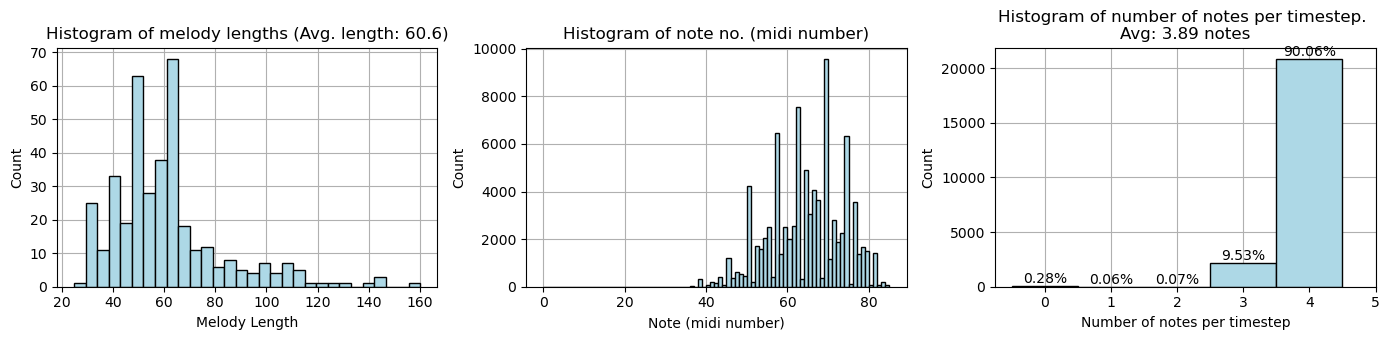

In [7]:
fig, axes = plt.subplots(figsize=(14, 3.5), ncols=3)

ax = axes[0]
lengths = [len(song) for song in data]
ax.hist(lengths, bins=30, color="lightblue", edgecolor="black")
ax.set_xlabel("Melody Length")
ax.set_ylabel("Count")
ax.set_title(f"Histogram of melody lengths (Avg. length: {np.mean(lengths):.1f})")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
notes = [note for chorale in data for t_note in chorale for note in t_note]
ax.hist(notes, bins=range(0, highest_note), color="lightblue", edgecolor="black")
ax.set_xlabel("Note (midi number)")
ax.set_ylabel("Count")
ax.set_title("Histogram of note no. (midi number)")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[2]
n_bins = np.max([len(t_notes) for chorale in data for t_notes in chorale])
bins = np.arange(n_bins+2)
notes_per_timestep = [len(t_notes) for chorale in data for t_notes in chorale]
ax.hist(notes_per_timestep, bins=bins, color="lightblue", edgecolor="black", align="left")
ax.set_xlabel("Number of notes per timestep")
ax.set_ylabel("Count")
ax.set_title(f"Histogram of number of notes per timestep. \nAvg: {np.mean(notes_per_timestep):.2f} notes")
ax.set_xticks(bins)
ax.grid(True)
ax.set_axisbelow(True)

for i, count in enumerate(np.bincount(notes_per_timestep)):
    ax.text(i, count, f"{count/len(notes_per_timestep)*100:.2f}%", ha="center", va="bottom")

fig.tight_layout()

In most of the quater-note intervals, four notes are played at a time. $0.28\%$ of the time, no note is played.

Let's look at the most common notes in the dataset.

In [8]:
K = 5

note_perc = np.bincount(notes)
note_perc = note_perc / np.sum(note_perc)
top_k = np.argsort(note_perc)[::-1][:K]

for note in top_k:
    print(f"{str_number_to_note(note)}: {note_perc[note]*100:.1f}%")

A5: 10.6%
D5: 8.4%
A4: 7.2%
D6: 7.0%
E5: 5.5%


Let's listen to two melodies from the dataset.

In [9]:
x_example = data[0]
write_mp3(x_example, "out/example_all.mp3")

audio_widget("out/example_all.mp3")

In [10]:
x_example = data[100]
write_mp3(x_example, "out/example_all_extra.mp3")

audio_widget("out/example_all_extra.mp3")

Let's split the data into training, validation and test set.

In [11]:
seqs_train_ = data[:310]
seqs_val_   = data[310:340]
seqs_test_  = data[340:]

In [12]:
print(f"Number of sequences in train: {len(seqs_train_)} ({len(seqs_train_) / len(data) * 100:.2f}%)")
print(f"Number of sequences in val: {len(seqs_val_)} ({len(seqs_val_) / len(data) * 100:.2f}%)")
print(f"Number of sequences in test: {len(seqs_test_)} ({len(seqs_test_) / len(data) * 100:.2f}%)")

Number of sequences in train: 310 (81.15%)
Number of sequences in val: 30 (7.85%)
Number of sequences in test: 42 (10.99%)


# Single note

In the first model, we assume a single note (or no note) is being played. A timestep where no note is being played will be encoded with the value 0. This does not create any issues with the MIDI-standard, since the MIDI-key 0 (lowest C) is not part of the dataset. Hence, we redefine what 0 means.

### Data Preprocessing

Let's extract the top voicings (notes).

In [13]:
def extract_top_part(data):
    single_data = []

    for sequence in data:
        notes = [[chords[-1]] if len(chords) > 0 else [0] for chords in sequence]
        single_data.append(notes)

    return single_data

In [14]:
seqs_train = extract_top_part(seqs_train_)
seqs_val   = extract_top_part(seqs_val_)
seqs_test  = extract_top_part(seqs_test_)

What does this sound like?

In [15]:
x_examples = seqs_train[0]
write_mp3(x_examples, "out/example_single.mp3")

audio_widget("out/example_single.mp3")

### HMM-0

A simple HMM model has already been implemented many times in the past. Nevertheless, we will implement it from scratch again. The implementation uses log probabilities to avoid numerical underflow. The model is trained using the Baum-Welch algorithm, and tests have been created to verify the correctness of the implementation. The Viterbi algorithm for predicing the most plausible hidden sequence has also been implemented and tested (see the repository). [Gregory Gundersen's blog](https://gregorygundersen.com/blog/2020/11/28/hmms/) is an excellent resource which derives the Baum-Welch algorithm (here it is assumed the emission probabilities follow a normal distribution and only a single sequence is trained on. In contrast, we support multiple sequences and assume the emisison probability distribution follows a categorial distribution. But the deriviation is almost identical).

In brief, the expectation-maximization (EM) algorithm for hidden markov models is called the Baum-Welch algorithm. The EM-algorithm contains two steps: 1. expectation step (E-step) and 2. maximization step (M-step).

- **E-step**: $Q(\mathbf{\theta} \mid \mathbf{\theta}^{(t)}) = \mathbb{E}_{p(\mathbf{x} \mid \mathbf{y}, \mathbf{\theta})} [\log p(\mathbf{x}, \mathbf{y} \mid \mathbf{\theta})]$
- **M-step**: $\mathbf{\theta}^{t+1} = \text{argmax}_{\mathbf{\theta}} Q(\mathbf{\theta} \mid \mathbf{\theta}^{(t)})$

where $\mathbf{x}$ are hidden random variables and $\mathbf{y}$ are the observed data.

The E-step for a hidden markov model is computed using the forward-backward algorithm (an algorithm which makes uses of the markov property and dynamic programming to make the expression computational tractable), in which $p(\mathbf{x}_n | \mathbf{y})$ and $p(\mathbf{x}_n, \mathbf{x}_{n-1} | \mathbf{y})$ are estimated. These quantities are afterwards used in the maximisation step (M-step) to estimate the parameters. The procedure of performing the E-step followed by the M-step repeats till convergence of the likelihood.

A classic hidden markov model is defined by the transition probabilities and the emission probabilities:

- Transition probabilities: $t := p(x_t \mid x_{t-1})$
- Emission probabilities: $e := p(y_t \mid x_{t})$


In the generative process, the transition and emission probability distribution each follow a categorical (multinomial) distribution, such that:
$$
x_t \sim \text{Cat}(x_t \mid \text{t}_{x_{t-1}}) \\
y_t \sim \text{Cat}(y_t \mid \text{e}_{x_{t}})
$$

Note $y_t$ is a single numeric value. Hence, it is assumed the sequences have only a single note (or no note) at each timestep.

Let's train the model on the training data. We assume it has 4 hidden states.

In [16]:
x_train = np.array([note[0] for song in seqs_train for note in song])
lengths = np.array([len(song) for song in seqs_train])

In [17]:
n_iter = 40

model = HMM(n_hidden=4, n_obs=highest_note+1)
model.fit(x_train, lengths, n_iter=n_iter)

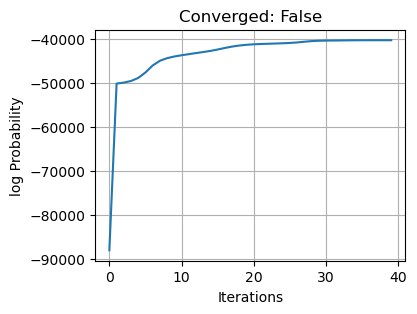

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(model._history)
ax.set_title(f"Converged: {len(model._history) < n_iter}")
ax.set_xlabel("Iterations")
ax.set_ylabel("log Probability")
ax.grid()

The model's likelihood actually converged. The criteria I use for early stopping in the implementation is much stricter. Hence, why it says it didn't converge.

We ignore the validation and test set for this model (only) to keep the model's implementation simple.


Let's sample from the trained model.

In [19]:
x_sample, state_sequence = model.sample(50)

Let's plot the generated sequence:

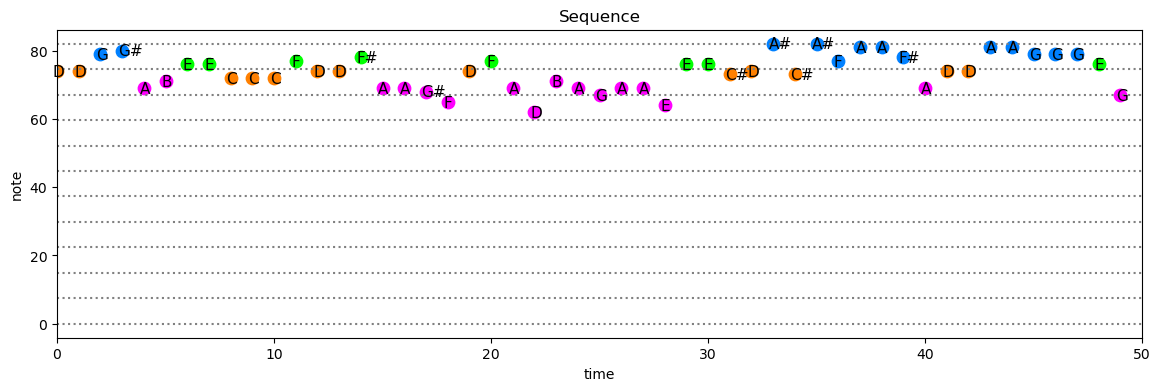

In [20]:
plot_sequence(idx_to_onehot(x_sample), state_sequence)

In the plot above, colors correspond to hidden states. 

For sampling purposes, it would be neat if each of the unique hidden states corresponded to a music scale. However, varying the number of hidden states to e.g., 12 (as there are 12 major scale) did not yield this "desired" result. Here each hidden state corresponds to a compact interval (no gaps between notes in the interval).

<Axes: title={'center': 'Transition matrix'}, xlabel='To', ylabel='From'>

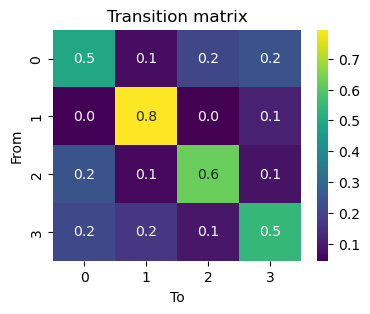

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
heatmap_transition_matrix(model.get_transition_matrix(), ax=ax)

What does the generated melody sound like?

In [22]:
write_mp3([[note] for note in x_sample], "out/hmm0_example.mp3")
audio_widget("out/hmm0_example.mp3")

In [23]:
x_sample, state_sequence = model.sample(50)

write_mp3([[note] for note in x_sample], "out/hmm0_example_extra.mp3")
audio_widget("out/hmm0_example_extra.mp3")

## Multiple notes

Let's now implement three HMMs using Pyro. These models support a variable number of notes being played in each timestep.

Probablistic frameworks such as Pyro allows inferring the posterior distribution of a model's parameters. We will not focus on the posterior distribution of the emission's and transition's probabilities (parameters). Instead, we will explore the MLE and MAP estimate of the model's parameters. By choosing the approximate posterior distribution of the parameters to follow a Delta distribution, i.e., a point distribution, a MAP estimate will be found. This is done by using the `AutoDelta` guide, i.e., the family of posterior distributions is the Delta distribution.

Note, since the models have a different number of parameters, it becomes impossible to compare the MAP loss using the test set. Thus, we opted to use the MLE estimate by setting the argument `include_prior=False` for each of these models. Hence, the prior of the parameters was not part of the loss. In practice, using the MLE estimate appeared to generate "nicer sounding" sequences by the models compared to the MAP estimate.

For the MAP estimate, our prior on transition probabilities was to stay in the same state with 90% probability and uniformly jump to another state with 10% probability. Our prior for the emission probabilities was to set a weak prior of 10% of the notes being active at any given time. Recall on avg. 4 out of 88 notes (there are 88 keys on a piano) were played at each time step.

In [24]:
def train(model, seqs_train, seqs_val, seqs_test, hidden_dim, batch_size, num_steps, lr=0.1, step_every=10):
    # prepare data
    sequences_train = torch.from_numpy(idx_to_onehot_multi(seqs_train)).float()
    lengths_train = torch.tensor([len(song) for song in seqs_train])

    sequences_val = torch.from_numpy(idx_to_onehot_multi(seqs_val)).float()
    lengths_val = torch.tensor([len(song) for song in seqs_val])

    sequences_test = torch.from_numpy(idx_to_onehot_multi(seqs_test)).float()
    lengths_test = torch.tensor([len(song) for song in seqs_test])

    pyro.clear_param_store()

    # setup optimizer and inference algorithm
    guide = AutoDelta(poutine.block(model, expose_fn=lambda msg: msg["name"].startswith("probs")))
    optim = ClippedAdam({"lr": lr})
    elbo = TraceEnum_ELBO(max_plate_nesting=2)
    svi = SVI(model, guide, optim, elbo)

    data_dim = sequences_train.shape[-1]

    train_losses = []
    val_losses = []

    for step in range(num_steps):

        # take a gradient step
        svi.step(sequences_train, lengths_train, data_dim=data_dim, hidden_dim=hidden_dim, batch_size=batch_size)

        # compute loss
        loss_train = svi.evaluate_loss(sequences_train, lengths_train, data_dim=data_dim, hidden_dim=hidden_dim, batch_size=batch_size)
        loss_train /= sequences_train.shape[0]

        loss_val = svi.evaluate_loss(sequences_val, lengths_val, data_dim=data_dim, hidden_dim=hidden_dim, batch_size=batch_size)
        loss_val /= sequences_val.shape[0]

        train_losses.append(loss_train)
        val_losses.append(loss_val)
            
        if step_every != -1 and step % step_every == 0:
            print(f"Step {step} - Train loss: {loss_train:.2f} - Validation loss: {loss_val:.2f}")

    test_loss = svi.evaluate_loss(sequences_test, lengths_test, data_dim=data_dim, hidden_dim=hidden_dim, batch_size=batch_size)
    test_loss /= sequences_test.shape[0]

    return {
        "model": model,
        "guide": guide,
        "data_dim": data_dim,

        "train_losses": train_losses,
        "val_losses": val_losses,
        "test_loss": test_loss,
    }

In [25]:
def sample(model, guide, n_samples, **model_kwargs):
    trained_model = poutine.condition(model, guide() if guide is not None else {})
    posterior_samples, posterior_hidden = trained_model(None, torch.tensor([n_samples]), **model_kwargs)

    posterior_samples = posterior_samples.numpy()
    posterior_hidden = posterior_hidden.numpy()

    return posterior_samples, posterior_hidden

### Data preprocessing

We will now use up to 4 notes per time step, i.e., all notes available in the dataset.

In [26]:
seqs_train = seqs_train_
seqs_val   = seqs_val_
seqs_test  = seqs_test_

### HMM-1

This model HMM-1 is similiar to the model HMM-0. However, it is *now* possible for the model to "guess" that multiple notes are playing at the same time step. To do this, we assume that at each timestep there are K observed values (instead of a single value) from K random variables, each being either 0 or 1.

In the generative process, the transition probability distribution follows a categorical (multinomial) distribution, and the emission probability distribution follows a Bernoulli distribution for each $y_k$, such that:
$$
x_t \sim \text{Cat}(x_t \mid \text{t}_{x_{t-1}}) \\
y_{t,k} \sim \text{Ber}(y_{t,k} \mid \text{e}^k_{x_{t}})
$$

Here $\mathbf{y}_t$ is a 88-dimensional vector (one element for each midi key). Hence, multiple notes may occur within the same timestep since there are  88 "independent" [note not played := 0, note played := 1] states. This is in contrast with HMM-0 which assumed a single distribution (categorial) across all notes, and therefore only supported a single note at a time.

In [27]:
def model_1(sequences, lengths, data_dim, hidden_dim, batch_size=None, include_prior=False):
    if sequences is not None:
        num_sequences, max_length, _ = map(int, sequences.shape)
    else:
        # when sampling, sample a single sequence
        num_sequences = 1
        max_length = lengths.max()

    assert lengths.shape == (num_sequences,)
    assert lengths.max() <= max_length
    
    with poutine.mask(mask=include_prior):
        probs_x = pyro.sample(
            "probs_x",
            dist.Dirichlet(0.9 * torch.eye(hidden_dim) + 0.1).to_event(1),
        )
        probs_y = pyro.sample(
            "probs_y",
            dist.Beta(0.1, 0.9).expand([hidden_dim, data_dim]).to_event(2),
        )
    
    notes_plate = pyro.plate("notes", data_dim, dim=-1)
    
    x_seq = torch.zeros(max_length, dtype=torch.long)
    y_seq = torch.zeros(max_length, data_dim, dtype=torch.long)

    # vectorize the batches
    with pyro.plate("sequences", num_sequences, batch_size, dim=-2) as batch:
        lens = lengths[batch]
        x = 0 # initial hidden state
        for t in pyro.markov(range(lens.max())):
            with poutine.mask(mask=(t < lens).unsqueeze(-1)):
                x = pyro.sample(
                    "x_{}".format(t),
                    dist.Categorical(probs_x[x]),
                    infer={"enumerate": "parallel"},
                ).long()
                x_seq[t] = x[0]

                with notes_plate:
                    y_seq[t] = pyro.sample(
                        "y_{}".format(t),
                        dist.Bernoulli(probs_y[x.squeeze(-1)]),
                        obs=sequences[batch, t] if sequences is not None else None,
                    )[0]

    return y_seq, x_seq

Let's define the parameters of the model.

In [28]:
model = model_1
hidden_dim = 6

... and the training parameters:

In [29]:
train_result = train(model, seqs_train, seqs_val, seqs_test, hidden_dim=hidden_dim, batch_size=16, num_steps=300, lr=0.05)

Step 0 - Train loss: 1243.41 - Validation loss: 1564.97
Step 10 - Train loss: 1525.50 - Validation loss: 1575.63
Step 20 - Train loss: 1145.53 - Validation loss: 1371.63
Step 30 - Train loss: 1239.94 - Validation loss: 1235.21
Step 40 - Train loss: 926.04 - Validation loss: 1103.19
Step 50 - Train loss: 1005.17 - Validation loss: 947.29
Step 60 - Train loss: 799.09 - Validation loss: 959.00
Step 70 - Train loss: 966.26 - Validation loss: 834.11
Step 80 - Train loss: 727.79 - Validation loss: 838.55
Step 90 - Train loss: 724.91 - Validation loss: 763.85
Step 100 - Train loss: 734.85 - Validation loss: 835.35
Step 110 - Train loss: 743.45 - Validation loss: 598.26
Step 120 - Train loss: 646.25 - Validation loss: 702.12
Step 130 - Train loss: 550.88 - Validation loss: 767.30
Step 140 - Train loss: 561.14 - Validation loss: 615.10
Step 150 - Train loss: 554.68 - Validation loss: 670.70
Step 160 - Train loss: 562.83 - Validation loss: 620.50
Step 170 - Train loss: 496.27 - Validation loss: 

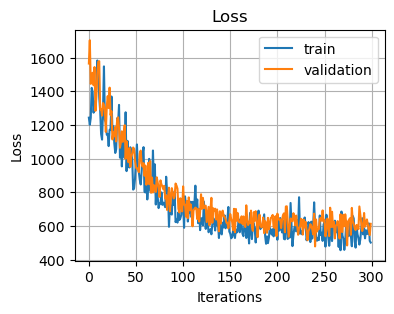

In [30]:
plot_loss(train_result["train_losses"], train_result["val_losses"])

In [31]:
print(f"Test loss: {train_result['test_loss']:.2f}")

Test loss: 581.51


Let's sample a sequence from the model and plot it.

In [32]:
model, guide, data_dim = train_result["model"], train_result["guide"], train_result["data_dim"]
posterior_samples, posterior_hidden = sample(model, guide, n_samples=100, data_dim=data_dim, hidden_dim=hidden_dim)

Let's take a look at the transition matrix and the distribution of the hidden states for the previously sampled data.

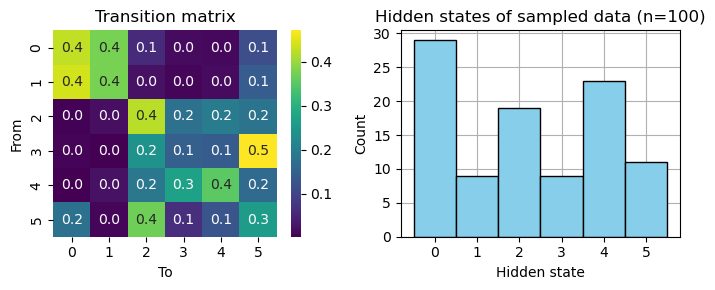

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
heatmap_transition_matrix(guide()["probs_x"].detach().numpy(), ax=axes[0])
plot_hidden_states_histogram(posterior_hidden, hidden_dim=hidden_dim, ax=axes[1])
fig.tight_layout()

Let's plot the sequence generated by the model:

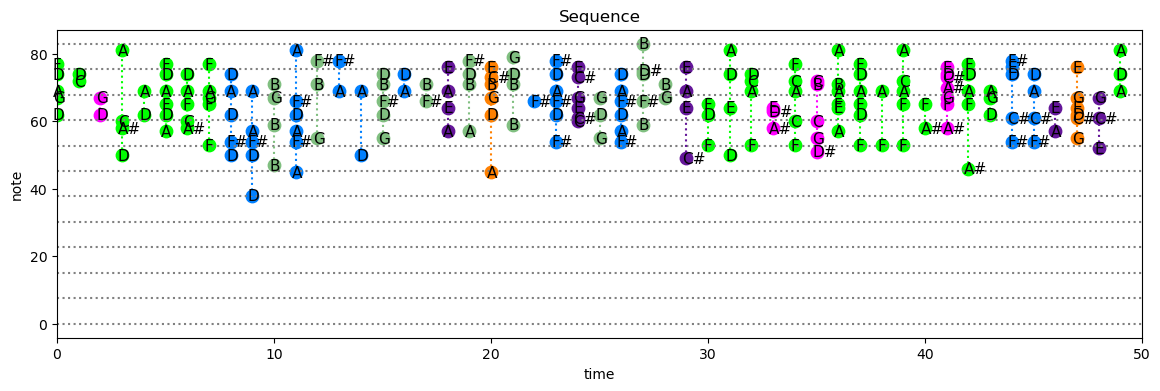

In [34]:
n = 50
plot_sequence(posterior_samples[:n], posterior_hidden[:n])

In [35]:
print(f"Average number of notes per timestep: {np.sum(posterior_samples) / len(posterior_samples)}")

Average number of notes per timestep: 3.88


The average number of midi notes per timestep is consistent with the data, which has on avg. 3.89 notes per timestep (see figure above in Data exploration).

Let's listen to the sample previously generated by the model:

In [36]:
x_samples = posterior_samples.astype(int)
x_example = [one_hot_to_idx(sequence) for sequence in x_samples]

write_mp3(x_example, "out/hmm1_example.mp3")
audio_widget("out/hmm1_example.mp3")

One more example for good measure.

In [37]:
posterior_samples, posterior_hidden = sample(model, guide, n_samples=50, data_dim=data_dim, hidden_dim=hidden_dim)

x_samples = posterior_samples.astype(int)
x_example = [one_hot_to_idx(sequence) for sequence in x_samples]

write_mp3(x_example, "out/hmm1_example_extra.mp3")
audio_widget("out/hmm1_example_extra.mp3")

Let's also just hear what the untrained HMM-1 model sounds like. <span style="color:red">Warning: horrible! </span>

In [38]:
posterior_samples, posterior_hidden = sample(model, guide=None, n_samples=50, data_dim=data_dim, hidden_dim=hidden_dim)

x_samples = posterior_samples.astype(int)
x_example = [one_hot_to_idx(sequence) for sequence in x_samples]

write_mp3(x_example, "out/hmm1_example_no_training.mp3", volume=70) # turn volume down from 100 to 70.
audio_widget("out/hmm1_example_no_training.mp3")

### HMM-2

This model HMM-2 is similiar to the model HMM-1. However, it assumes the previously observed value influences the next observed value as well.

In the generative process, the transition probability distribution follows a categorical (multinomial) distribution, and the emission probability distribution follows a Bernoulli distribution for each $y_k$:
$$
x_t \sim \text{Cat}(x_t \mid \text{t}_{x_{t-1}}) \\
y_{t,k} \sim \text{Ber}(y_{t,k} \mid \text{e}^k_{x_{t}, y_{t-1}})
$$

Thus, the emission probabilities of $y_{t,k}$ is conditioned on both the hidden state $x_t$ and the previous state $y_{t-1,k}$ for that particular note.
Again, $\mathbf{y}_t$ is a 88-dimensional vector (each of the midi keys). Hence, multiple notes may occur within the same timestep since there are  88 "independent" [note not played := 0, note played := 1] states.

In [39]:
def model_2(sequences, lengths, data_dim, hidden_dim, batch_size=None, include_prior=False):
    if sequences is not None:
        num_sequences, max_length, _ = map(int, sequences.shape)
    else:
        # when sampling, sample a single sequence
        num_sequences = 1
        max_length = lengths.max()

    assert lengths.shape == (num_sequences,)
    assert lengths.max() <= max_length
    
    with poutine.mask(mask=include_prior):
        probs_x = pyro.sample(
            "probs_x",
            dist.Dirichlet(0.9 * torch.eye(hidden_dim) + 0.1).to_event(1),
        )
        probs_y = pyro.sample(
            "probs_y",
            dist.Beta(0.1, 0.9).expand([hidden_dim, 2, data_dim]).to_event(3),
        )
    
    notes_plate = pyro.plate("notes", data_dim, dim=-1)
    
    x_seq = torch.zeros(max_length, dtype=torch.long)
    y_seq = torch.zeros(max_length, data_dim, dtype=torch.long)

    # vectorize the batches
    with pyro.plate("sequences", num_sequences, batch_size, dim=-2) as batch:
        lens = lengths[batch]
        x = 0 # initial state
        y = 0 # "imaginary" state before initial state
        for t in pyro.markov(range(lens.max())):
            with poutine.mask(mask=(t < lens).unsqueeze(-1)):
                x = pyro.sample(
                    "x_{}".format(t),
                    dist.Categorical(probs_x[x]),
                    infer={"enumerate": "parallel"},
                ).long()
                x_seq[t] = x[0]

                with notes_plate as notes:
                    y = pyro.sample(
                        "y_{}".format(t),
                        dist.Bernoulli(probs_y[x, y, notes]),
                        obs=sequences[batch, t] if sequences is not None else None,
                    ).long()
                    y_seq[t] = y[0]

    return y_seq, x_seq

Let's define the parameters of the model.

In [40]:
model = model_2
hidden_dim = 6

... and the training parameters:

In [41]:
train_result = train(model, seqs_train, seqs_val, seqs_test, hidden_dim=hidden_dim, batch_size=16, num_steps=300, lr=0.05)

Step 0 - Train loss: 1418.46 - Validation loss: 1460.09
Step 10 - Train loss: 1216.16 - Validation loss: 1442.29
Step 20 - Train loss: 1232.59 - Validation loss: 1174.72
Step 30 - Train loss: 1164.27 - Validation loss: 1054.34
Step 40 - Train loss: 1012.88 - Validation loss: 1005.23
Step 50 - Train loss: 788.73 - Validation loss: 899.43
Step 60 - Train loss: 821.69 - Validation loss: 820.73
Step 70 - Train loss: 978.15 - Validation loss: 835.97
Step 80 - Train loss: 808.43 - Validation loss: 677.82
Step 90 - Train loss: 665.08 - Validation loss: 740.83
Step 100 - Train loss: 684.80 - Validation loss: 686.98
Step 110 - Train loss: 663.88 - Validation loss: 593.84
Step 120 - Train loss: 691.21 - Validation loss: 642.72
Step 130 - Train loss: 542.15 - Validation loss: 648.29
Step 140 - Train loss: 556.80 - Validation loss: 578.44
Step 150 - Train loss: 593.94 - Validation loss: 579.07
Step 160 - Train loss: 605.35 - Validation loss: 658.53
Step 170 - Train loss: 518.65 - Validation loss: 

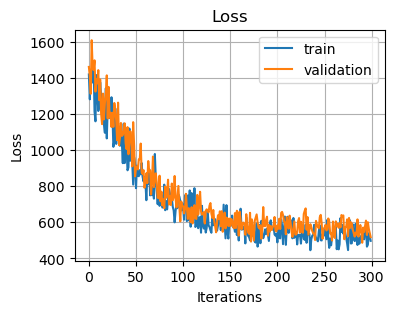

In [42]:
plot_loss(train_result["train_losses"], train_result["val_losses"])

In [43]:
print(f"Test loss: {train_result['test_loss']:.2f}")

Test loss: 475.59


Let's sample a sequence from the model and plot it.

In [44]:
model, guide, data_dim = train_result["model"], train_result["guide"], train_result["data_dim"]

posterior_samples, posterior_hidden = sample(model, guide, n_samples=100, data_dim=data_dim, hidden_dim=hidden_dim)

Let's take a look at the transition matrix and the distribution of the hidden states for the previously sampled data.

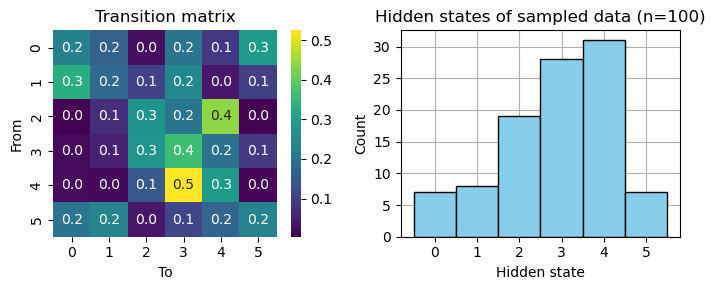

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
heatmap_transition_matrix(guide()["probs_x"].detach().numpy(), ax=axes[0])
plot_hidden_states_histogram(posterior_hidden, hidden_dim=hidden_dim, ax=axes[1])
fig.tight_layout()

Let's plot the sequence generated by the model:

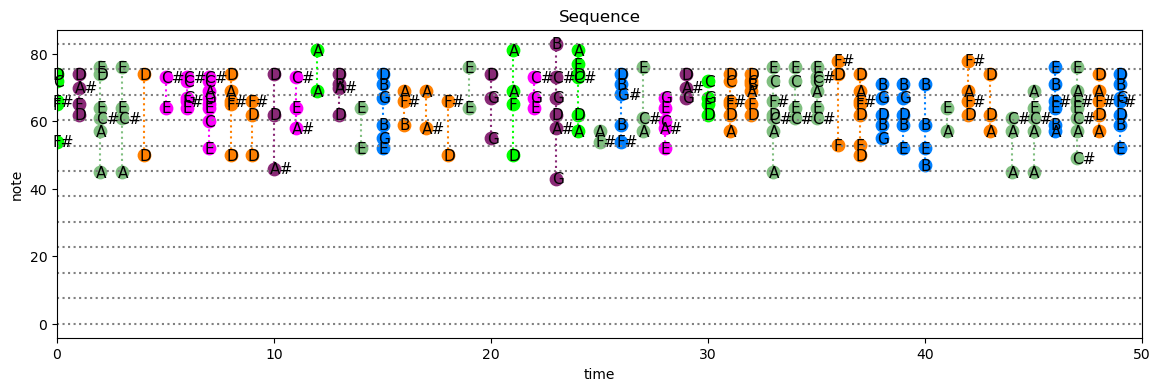

In [46]:
n = 50
plot_sequence(posterior_samples[:n], posterior_hidden[:n])

In [47]:
print(f"Average number of notes per timestep: {np.sum(posterior_samples) / len(posterior_samples)}")

Average number of notes per timestep: 3.88


The average number of midi notes per timestep is consistent with the data, which has on avg. 3.89 notes per timestep (see figure above in Data exploration).

Let's listen to the sample previously generated by the model:

In [48]:
x_samples = posterior_samples.astype(int)
x_example = [one_hot_to_idx(sequence) for sequence in x_samples]

write_mp3(x_example, "out/hmm2_example.mp3")
audio_widget("out/hmm2_example.mp3")

One more example for good measure.

In [49]:
posterior_samples, posterior_hidden = sample(model, guide, n_samples=50, data_dim=data_dim, hidden_dim=hidden_dim)

x_samples = posterior_samples.astype(int)
x_example = [one_hot_to_idx(sequence) for sequence in x_samples]

write_mp3(x_example, "out/hmm2_example_extra.mp3")
audio_widget("out/hmm2_example_extra.mp3")

### HMM-3

This model HMM-3 is similiar to the model HMM-1. However, it looks at the previous 2 hidden states (instead of 1 hidden state) to determine the transition probability.
In the generative process the transition probability distribution follows a categorical (multinomial) distribution, and the emission probability distribution follows a Bernoulli distribution for each $y_k$:
$$
x_t \sim \text{Cat}(x_t \mid \text{t}_{x_{t-1}, x_{t-2}}) \\
y_{t,k} \sim \text{Ber}(y_{t,k} \mid \text{e}^k_{x_{t}})
$$

Again $\mathbf{y}_t$ is a 88-dimensional vector (each of the midi keys). Hence, multiple notes may occur within the same timestep since there are  88 "independent" [note not played := 0, note played := 1] states.

In [50]:
def model_3(sequences, lengths, data_dim, hidden_dim, batch_size=None, include_prior=False):
    if sequences is not None:
        num_sequences, max_length, _ = map(int, sequences.shape)
    else:
        # when sampling, sample a single sequence
        num_sequences = 1
        max_length = lengths.max()

    assert lengths.shape == (num_sequences,)
    assert lengths.max() <= max_length

    with poutine.mask(mask=include_prior):
        probs_x = pyro.sample(
            "probs_x",
            dist.Dirichlet(0.9 * torch.eye(hidden_dim) + 0.1).expand([hidden_dim, hidden_dim]).to_event(2),
        )
        probs_y = pyro.sample(
            "probs_y",
            dist.Beta(0.1, 0.9).expand([hidden_dim, data_dim]).to_event(2),
        )

    notes_plate = pyro.plate("notes", data_dim, dim=-1)
    
    x_seq = torch.zeros(max_length, dtype=torch.long)
    y_seq = torch.zeros(max_length, data_dim, dtype=torch.long)

    # vectorize the batches
    with pyro.plate("sequences", num_sequences, batch_size, dim=-2) as batch:
        lens = lengths[batch]
        x_curr = torch.tensor(0)
        x_prev = torch.tensor(0)
        for t in pyro.markov(range(lens.max()), history=2):
            with poutine.mask(mask=(t < lens).unsqueeze(-1)):
                probs_x_t = Vindex(probs_x)[x_prev, x_curr]
                x_prev, x_curr = x_curr, pyro.sample(
                    "x_{}".format(t),
                    dist.Categorical(probs_x_t),
                    infer={"enumerate": "parallel"},
                ).long()
                x_seq[t] = x_curr[0]

                with notes_plate:
                    y_seq[t] = pyro.sample(
                        "y_{}".format(t),
                        dist.Bernoulli(probs_y[x_curr.squeeze(-1)]),
                        obs=sequences[batch, t] if sequences is not None else None,
                    )[0]

    return y_seq, x_seq

In [51]:
model = model_3
hidden_dim = 10

... and the training parameters:

In [52]:
train_result = train(model, seqs_train, seqs_val, seqs_test, hidden_dim=hidden_dim, batch_size=16, num_steps=300, lr=0.05)

Step 0 - Train loss: 1273.28 - Validation loss: 1601.72
Step 10 - Train loss: 1118.40 - Validation loss: 1300.72
Step 20 - Train loss: 1100.37 - Validation loss: 1177.54
Step 30 - Train loss: 1012.67 - Validation loss: 1010.07
Step 40 - Train loss: 942.26 - Validation loss: 1034.64
Step 50 - Train loss: 794.80 - Validation loss: 887.43
Step 60 - Train loss: 835.23 - Validation loss: 826.78
Step 70 - Train loss: 657.88 - Validation loss: 834.84
Step 80 - Train loss: 764.37 - Validation loss: 722.42
Step 90 - Train loss: 833.10 - Validation loss: 635.83
Step 100 - Train loss: 710.51 - Validation loss: 726.07
Step 110 - Train loss: 569.00 - Validation loss: 632.08
Step 120 - Train loss: 462.40 - Validation loss: 644.52
Step 130 - Train loss: 639.77 - Validation loss: 618.04
Step 140 - Train loss: 562.12 - Validation loss: 629.41
Step 150 - Train loss: 514.35 - Validation loss: 519.52
Step 160 - Train loss: 514.01 - Validation loss: 581.79
Step 170 - Train loss: 651.64 - Validation loss: 6

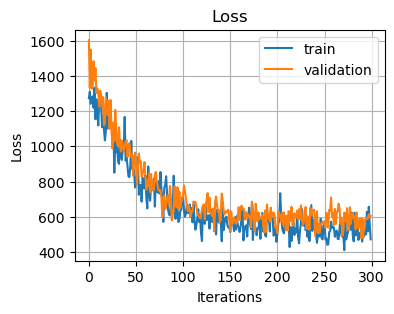

In [53]:
plot_loss(train_result["train_losses"], train_result["val_losses"])

In [54]:
print(f"Test loss: {train_result['test_loss']:.2f}")

Test loss: 580.74


Let's sample a sequence from the model and plot it.

In [55]:
model, guide, data_dim = train_result["model"], train_result["guide"], train_result["data_dim"]

posterior_samples, posterior_hidden = sample(model, guide, n_samples=100, data_dim=data_dim, hidden_dim=hidden_dim)

<Axes: title={'center': 'Hidden states of sampled data (n=100)'}, xlabel='Hidden state', ylabel='Count'>

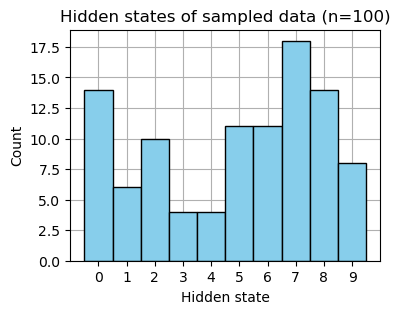

In [56]:
plot_hidden_states_histogram(posterior_hidden, hidden_dim=hidden_dim)

Let's plot the sequence generated by the model:

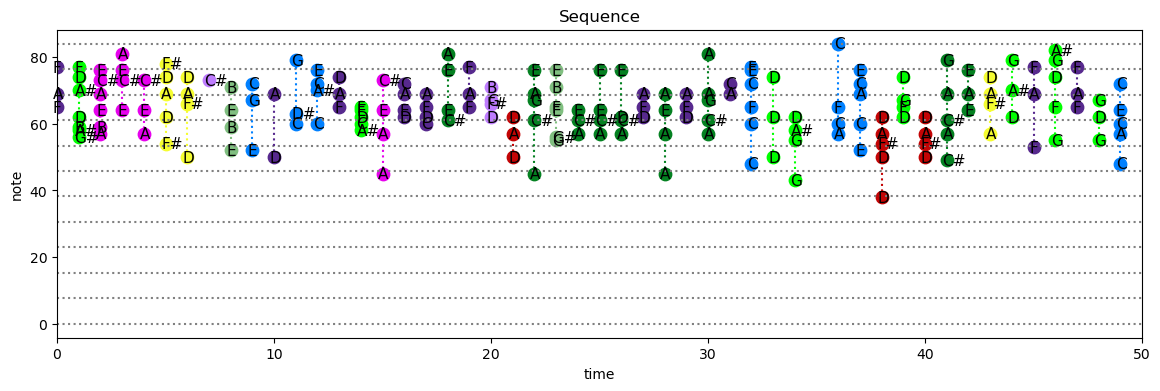

In [57]:
n = 50
plot_sequence(posterior_samples[:n], posterior_hidden[:n])

The above plot suggest that each hidden state corresponds to a small musical phrase.

In [58]:
print(f"Average number of notes per timestep: {np.sum(posterior_samples) / len(posterior_samples)}")

Average number of notes per timestep: 3.64


The average number of midi notes per timestep is consistent with the data, which has on avg. 3.89 notes per timestep (see figure above in Data exploration).

Let's listen to the sample previously generated by the model:

In [59]:
x_samples = posterior_samples.astype(int)
x_example = [one_hot_to_idx(sequence) for sequence in x_samples]

write_mp3(x_example, "out/hmm3_example.mp3")
audio_widget("out/hmm3_example.mp3")

One more example for good measure.

In [60]:
posterior_samples, posterior_hidden = sample(model, guide, n_samples=50, data_dim=data_dim, hidden_dim=hidden_dim)

x_samples = posterior_samples.astype(int)
x_example = [one_hot_to_idx(sequence) for sequence in x_samples]

write_mp3(x_example, "out/hmm3_example_extra.mp3")
audio_widget("out/hmm3_example_extra.mp3")

## Conclusion

In this project, we first implemented a HMM from scratch, which assumed a single note per timestep. We then implemented more complex models that allowed for multiple notes per timestep - using Pyro. We trained the models on a dataset of Bach chorales and generated new sequences of notes. The models were able to generate sequences that sounded like music and had a "Bach-like flavor" to them. The model with the smallest loss on the test set was HMM-2. Increasing the number of hidden states had little to no effect on the loss for the train and validation set on any of the models. We explored up to 32 hidden states ($32 \times 32$ hidden states for model 3). HMM-3 generated arguably the best sounding sequences.

In most music pieces, notes have variable lengths. In the JSB chorales dataset, all notes had the same duration (one quarter note each). A simple solution to handle music pieces with variable length notes would be to set a models "timesteps" to the smallest note duration and cut notes with larger duration into multiple of smaller (and same) durations. To handle larger notes being played ("pressed") longer (multiple "timesteps"), a HMM variant may include an encoding of a note being "pressed" and "released". In the models implemented in this project, the data is preprocessed such as a 0 corresponds to not pressed and 1 as pressed; but there is subtle difference between "not pressed" and "released".